# Appendix 6 - Data storage handler

This data handler use PyTables that is built on top of the HDF5 library, using the Python language and the NumPy package. It features an object-oriented interface that, combined with C extensions for the performance-critical parts of the code (generated using Cython), makes it a fast, yet extremely easy to use tool for interactively browse, process and search very large amounts of data. One important feature of PyTables is that it optimizes memory and disk resources so that data takes much less space (specially if on-flight compression is used) than other solutions such as relational or object oriented databases.

In [1]:
import tables
import numpy as np
import json
from datetime import datetime

In [2]:
filename = 'sampple_eeg.h5'
CHANNELS = 16

In [3]:
from openbci_stream.handlers import HDF5_Writer, HDF5_Reader

## Writer

In [4]:
from openbci_stream.handlers import HDF5_Writer

writer = HDF5_Writer('output.h5')

### Add header

In [5]:
header = {'sample_rate': 1000,
          'datetime': datetime.now().timestamp(),
         }
writer.add_header(header)

### Add EEG data

In [8]:
eeg = np.random.normal(size=(16, 1000))  # channels x data
writer.add_eeg(eeg)

In [ ]:
# The number of channels cannot be changed after define the first package
eeg = np.random.normal(size=(8, 1000))
writer.add_eeg(eeg)

In [10]:
# The number of data can be changed
eeg = np.random.normal(size=(16, 500))
writer.add_eeg(eeg)

A `timestamp` can be added to the data, in a separated command:

In [11]:
eeg = np.random.normal(size=(16, 2000))
timestamp = np.array([datetime.now().timestamp()]*2000)

writer.add_eeg(eeg)
writer.add_timestamp(timestamp)

or in the same command:

In [12]:
eeg = np.random.normal(size=(16, 2000))
timestamp = [datetime.now().timestamp()] * 2000

writer.add_eeg(eeg, timestamp)

There is something special about the `timestamp`, is not necessary to define all ones, if zeros are placed between the time series, there will be extrapolated during the reading.

In [13]:
timestamp = np.zeros(len(eeg))
timestamp[-1] = datetime.now().timestamp()

writer.add_eeg(eeg, timestamp)

The above code can be written simply as:

In [14]:
eeg = np.random.normal(size=(16, 2000))
timestamp = datetime.now().timestamp()

writer.add_eeg(eeg, timestamp)

### Add markers
 Is composed of `marker` itself and `timestamp`:

In [15]:
timestamp = datetime.now().timestamp()
marker = 'LEFT'

writer.add_marker(marker, timestamp)

### Add annotations

The annotations are defined like in EDF format, with an `onset` and `duration` in seconds, and the correspondent `description`

In [6]:
writer.add_annotation(onset=5, duration=1, description='This is an annotation, in EDF style')
writer.add_annotation(onset=45, duration=15, description='Electrode verification')
writer.add_annotation(onset=50, duration=3, description='Patient blinking')

Do no forget to close the file

In [7]:
writer.close()

## Reader

In [8]:
reader = HDF5_Reader('output.h5')

reader.header

{'sample_rate': 1000, 'datetime': 1602301092.417758}

In [18]:
reader.eeg

/eeg_data (EArray(9500, 16)) 'EEG time series'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (512, 16)

In [19]:
reader.markers

{'LEFT': [1590861330.461455]}

In [20]:
reader.f.root.eeg_data

/eeg_data (EArray(9500, 16)) 'EEG time series'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (512, 16)

In [21]:
reader.f.root.timestamp

/timestamp (EArray(8000,)) 'EEG timestamp'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (8192,)

In [22]:
reader.timestamp

array([1.59086127e+09, 1.59086127e+09, 1.59086127e+09, ...,
       1.59086133e+09, 1.59086133e+09, 1.59086133e+09])

In [9]:
reader.annotations

[[5, 1, 'This is an annotation, in EDF style'],
 [45, 15, 'Electrode verification'],
 [50, 3, 'Patient blinking']]

## Examples using the `with` control-flow structure

This data format handlers can be used with the `with` structure, what makes the manipulation of files easier because the format needs that they are correctly opened and closed. 

### Writer

In [1]:
from openbci_stream.handlers import HDF5_Writer
from datetime import datetime, timedelta
import numpy as np

now = datetime.now()

header = {'sample_rate': 1000,
          'datetime': now.timestamp(),
          'montage': 'standard_1020',
          'channels': {i:ch for i, ch in enumerate('Fp1,Fp2,F7,Fz,F8,C3,Cz,C4,T5,P3,Pz,P4,T6,O1,Oz,O2'.split(','))},
         }

filename = f'sample-{now.timestamp()}.h5'
with HDF5_Writer(filename) as writer:

    writer.add_header(header)
    
    for i in range(60*30):
        eeg = np.random.normal(size=(16, 1000))
        aux = np.random.normal(size=(3, 1000))
        timestamp = (now + timedelta(seconds=i)).timestamp()
        writer.add_eeg(eeg, timestamp)
        writer.add_aux(aux)

### Reader

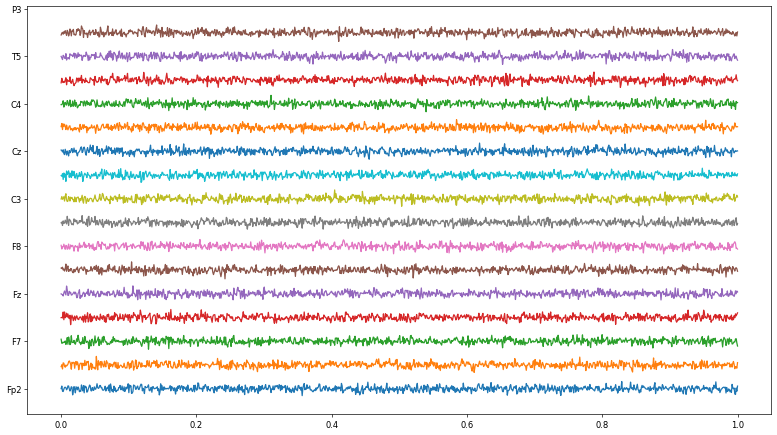

In [6]:
from openbci_stream.handlers import HDF5_Reader
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 9), dpi=60)

ax = plt.subplot(111)
with HDF5_Reader(filename) as reader:
    
    channels = reader.header['ch_names']
    sample_rate = reader.header['sample_rate']

    t = np.linspace(0, 1, sample_rate)
    for i, ch in enumerate(reader.eeg[:sample_rate]):
        plt.plot(t, (ch-ch.mean())*0.1+i)
    ax.set_yticklabels(channels)